# CPU analysis of single-cell ATAC-seq data from 60K cells

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

### Import requirements

In [1]:
%%time
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from collections import OrderedDict

import time
import os

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')

CPU times: user 1.24 s, sys: 148 ms, total: 1.39 s
Wall time: 1.41 s


## Set parameters

In [2]:
# filtering peaks
n_top_peaks = 25000 # Number of peaks to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE
n_jobs=32

# KNN
n_neighbors = 10 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.4 
umap_spread = 1.0

# Differential peaks
n_diff_peaks = 50 # Number of differential peaks to compute for each cluster

# Marker genes
# Gene coordinates are in GRCh37, from grch37.ensembl.org
markers = ['MS4A1', 'LEF1', 'NKG7', 'TREM1', 'GATA1', 'PAX5']
marker_coords = OrderedDict()
marker_coords['MS4A1'] = ['chr11', 60223225, 60238233, 'fwd']
marker_coords['LEF1'] = ['chr4', 108968701, 109090112, 'rev']
marker_coords['NKG7'] = ['chr19', 51874860, 51875969, 'rev']
marker_coords['TREM1'] = ['chr6', 41235664, 41254457, 'rev']
marker_coords['GATA1'] = ['chrX', 48644962, 48652716, 'fwd']
marker_coords['PAX5'] = ['chr9', 36833272, 37034103, 'rev']

In [3]:
start_time = time.time()

## Input data

In [4]:
%%time
adata = anndata.read_h5ad('../data/dsci_resting_nonzeropeaks.h5ad')
adata_raw = adata.copy()

CPU times: user 180 ms, sys: 172 ms, total: 352 ms
Wall time: 350 ms


## Preprocessing

In [5]:
preprocessing_start = time.time()

### tf-idf normalization

We use log1p(pseudocount / tf)\*idf, motivated by discussion in [this blog post](http://andrewjohnhill.com/blog/2019/05/06/dimensionality-reduction-for-scatac-data/) as well as our results on various scATAC datasets.

In [6]:
%%time
lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

CPU times: user 2.08 s, sys: 480 ms, total: 2.56 s
Wall time: 2.56 s


### Frequency-based peak selection

In [7]:
%%time
peak_frequency = np.array(np.sum(adata.X > 0, axis=0) / adata.X.shape[0]).flatten()
frequent_peak_idxs = np.argsort(peak_frequency)

CPU times: user 332 ms, sys: 88.1 ms, total: 420 ms
Wall time: 419 ms


In [8]:
%%time
use = frequent_peak_idxs[-n_top_peaks : ]
adata = adata[:, use]

CPU times: user 9.89 ms, sys: 412 µs, total: 10.3 ms
Wall time: 9.57 ms


In [9]:
print("Preprocessing time: %.2fsec" % (time.time() - preprocessing_start))

Preprocessing time: 3.01sec


## Cluster & Visualize

### PCA

In [10]:
%%time
sc.pp.pca(adata, n_comps = n_components)

CPU times: user 56min 29s, sys: 1min 14s, total: 57min 44s
Wall time: 2min 40s


### kNN + Louvain clustering, UMAP visualization

In [11]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 29.9 s, sys: 2.83 s, total: 32.8 s
Wall time: 32.6 s


In [12]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 2min 52s, sys: 2.59 s, total: 2min 55s
Wall time: 1min


In [13]:
%%time
sc.tl.louvain(adata)

CPU times: user 6.07 s, sys: 48.1 ms, total: 6.12 s
Wall time: 6.1 s


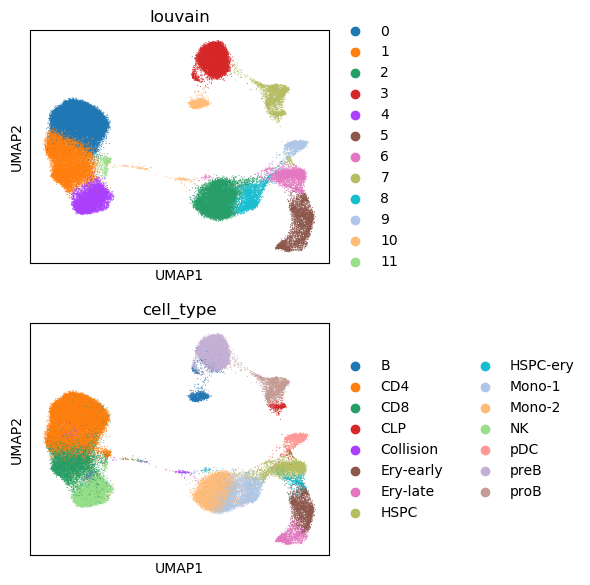

CPU times: user 2.07 s, sys: 16 ms, total: 2.08 s
Wall time: 2.08 s


In [14]:
%%time

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (6, 6), dpi=100)

sc.pl.umap(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.umap(adata, color=['cell_type'], ax=axs[1], show=False)

plt.tight_layout()
plt.show()

### tSNE visualization

In [15]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, n_jobs=n_jobs)

CPU times: user 2h 15min 39s, sys: 2min 59s, total: 2h 18min 38s
Wall time: 3min 57s


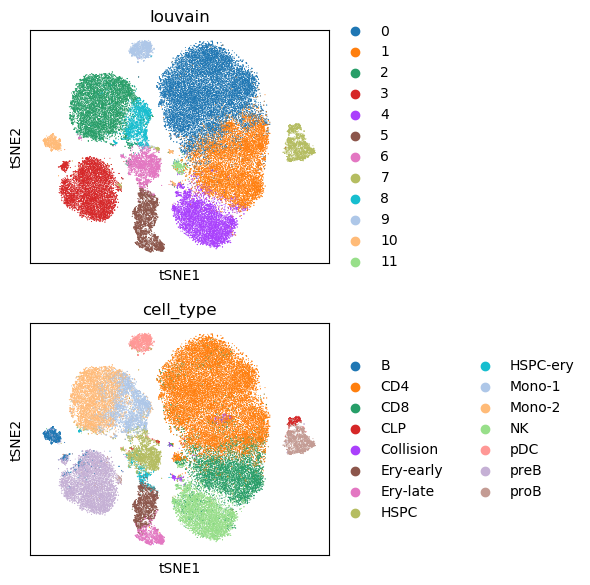

CPU times: user 10.5 s, sys: 219 ms, total: 10.7 s
Wall time: 2.15 s


In [16]:
%%time

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (6, 6), dpi=100)

sc.pl.tsne(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.tsne(adata, color=['cell_type'], ax=axs[1], show=False)

plt.tight_layout()
plt.show()

### Visualize marker gene activities

We use the raw adata object to compute gene activity scores. This allows us to consider all peaks, not just the subset we used for clustering and UMAP.

In [17]:
%%time
# find which peaks overlap with each marker gene (+ 5kb upstream)
peaks_per_gene = {gene : [] for gene in markers}

for (i, peak) in enumerate(adata_raw.var_names):
    chrom, coords = peak.strip().split(':')
    start, end = [int(c) for c in coords.split('-')]
    for gene in markers:
        if utils.overlap(marker_coords[gene], [chrom, start, end], 5000, 0):
            peaks_per_gene[gene].append((i, peak))

for gene in peaks_per_gene:
    print(f"{gene} has {len(peaks_per_gene[gene])} nearby peaks")

MS4A1 has 2 nearby peaks
LEF1 has 30 nearby peaks
NKG7 has 4 nearby peaks
TREM1 has 5 nearby peaks
GATA1 has 6 nearby peaks
PAX5 has 30 nearby peaks
CPU times: user 667 ms, sys: 38 µs, total: 667 ms
Wall time: 665 ms


In [18]:
%%time
# Calculate per-cell gene activity scores for each marker gene
cell_gene_scores = np.zeros((adata.X.shape[0], len(marker_coords.keys())))
for (i, gene) in enumerate(peaks_per_gene.keys()):
    indices = [x[0] for x in peaks_per_gene[gene]]
    peak_scores = adata_raw.X[:, indices].toarray()
    cell_gene_scores[:, i] = np.sum(peak_scores, axis=1) + 1

# Store per-cell gene activity scores with adata
for (i, gene) in enumerate(markers):
    adata.obs[gene] = np.log2(cell_gene_scores[:, i].tolist())
    adata.obs.loc[np.isneginf(adata.obs[gene]), gene] = 0

CPU times: user 793 ms, sys: 4.02 ms, total: 797 ms
Wall time: 795 ms


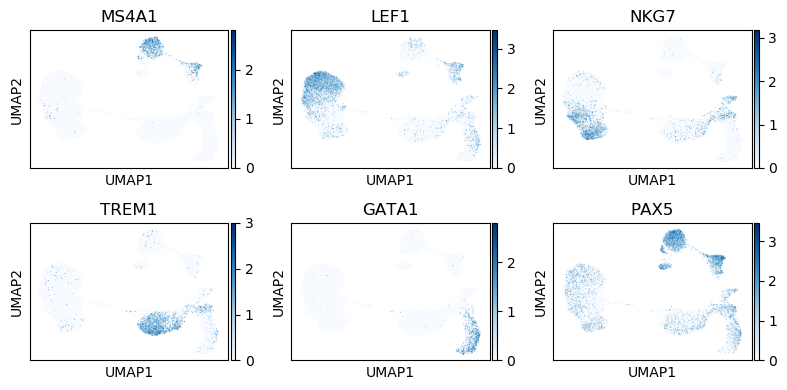

CPU times: user 4.79 s, sys: 16.1 ms, total: 4.8 s
Wall time: 4.8 s


In [19]:
%%time

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (8, 4), dpi=100)
axs = axs.flatten()
for (i, gene) in enumerate(markers):
    sc.pl.umap(adata, color_map="Blues", color=gene, ax = axs[i], show=False)
plt.tight_layout()
plt.show()

## Find differential peaks

We use a logistic regression model to find peaks that show differential activity across clusters. Here, we needed to increase the maximum number of iterations to 1200 for the model to converge.

In [20]:
%%time
sc.tl.rank_genes_groups(adata, 
                        groupby="louvain", 
                        n_genes=n_diff_peaks, 
                        groups='all', 
                        reference='rest',
                        method='logreg',
                        max_iter=1200
                       )

CPU times: user 3h 43min 9s, sys: 10min 31s, total: 3h 53min 40s
Wall time: 18min 31s


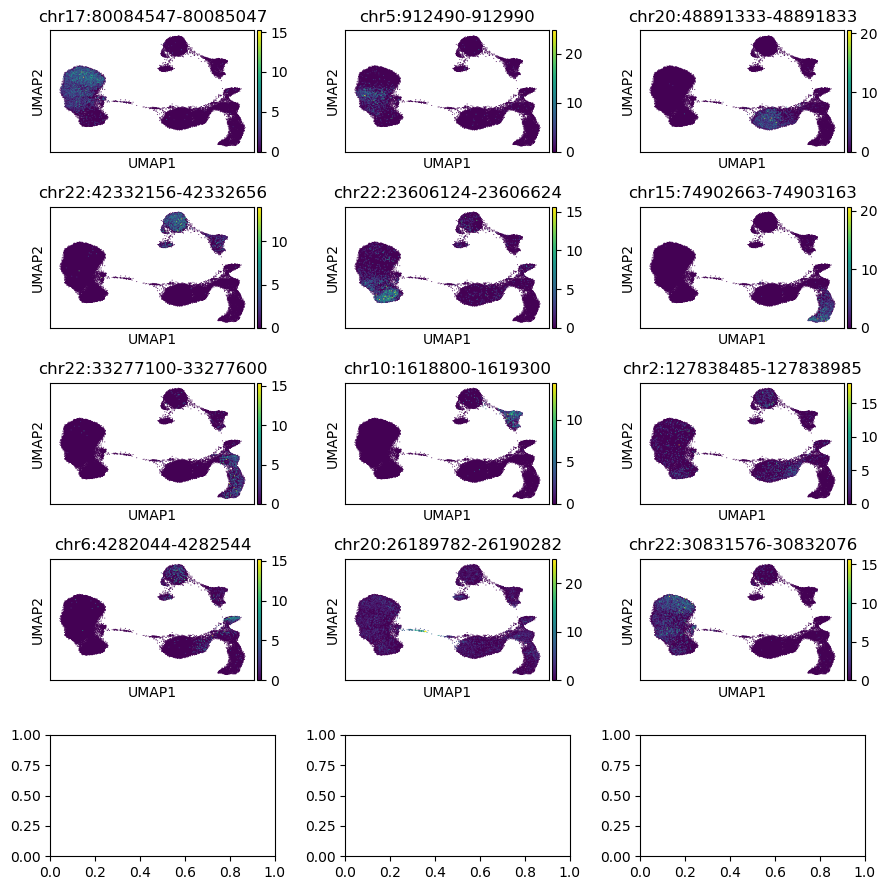

CPU times: user 14.2 s, sys: 146 ms, total: 14.4 s
Wall time: 11.1 s


In [21]:
%%time

fig, axs = plt.subplots(len(adata.uns['rank_genes_groups']['names'][0])//3 + 1, 3, figsize=(9,9), dpi=100)
axs = axs.flatten()

for (i, peak) in enumerate(adata.uns['rank_genes_groups']['names'][0]):
    sc.pl.umap(adata, color=peak, 
           ax=axs[i], show=False,
           vmax=min(25, np.max(adata[:,peak].X)),
           cmap='viridis'
          )
plt.tight_layout()
plt.show()

In [22]:
print("Full time: %s" % (time.time() - start_time))

Full time: 1634.2012920379639
